# Intensity modeling in HELIOS++
Authors: Lukas Winiwarter, Alberto Esmorís, Hannah Weiser, Bernhard Höfle \
December 2023

## Introduction

HELIOS++ supports simulation of full waveform data by simulating a laser beam cone of finite divergence via sampled subrays. This notebook documents the sampling procedure and the calculation of subray target area and subray power for the case of an extended flat target.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import enum
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

def polar2cart(r, phi):
    """convert polar coordinates to cartesian coordinates"""
    return (r*np.sin(phi), r*np.cos(phi))

## Variables

- $\beta$ = beam divergence [mrad; full angle at $1/e^2$ points]
- $\vartheta_{FOV}$ = Receiver field of view 
- $w_0$ = Beam waist radius [mm]
- $R_0$ = Focusing range / Minimum range of the device [m]
- $w$ = Beam radius at a specific distance [mm]
- $P_{tot}$ = Total power [W]
- $\eta_{syst}$ = Efficiency of the system
- $\eta_{atm}$ = Efficiency of the atmosphere
- $D_r$ = Diameter of the receiver aperture [m]
- $\sigma$ = Laser cross section

---
- $R$ = Range [m]
- $\alpha$ = Incidence angle [°]
- $\rho$ = Reflectance
- $k_s$ = Specular reflectance parameter
- $Ns$ = Specular exponent

---
**HELIOS++-specific**:
- $BSQ$ = Beam Sample Quality (governs the number of concentric circles for approximating beam divergence using subrays)
- $BQ$ = Beam Quality Factor (how well the beam is focussed)

In [2]:
# set fix variables

# system properties
beam_div = 0.3 / 1000 # [rad], 1/e2 points (full angle)
receiver_fov = beam_div
tot_power = 4  # [W]
eta_atm = 1  # efficiency of the atmosphere
eta_sys = 1  # efficiency of the system
D_r = 1  # diameter of the receiver aperture [m]
wavelength = 1064 * 1e-9  # [m]
R_0 = 1.5  # minimum range [m]
BQ = 2

# range + target properties
R = 10  # range [m]
reflectance = 0.5
spec = 0.5  # weight for the specular contribution; only used in the Phong model
Ns = 10
alpha = 0 * np.pi/180  # incidence angle

## Irradiance and beam sampling

For computing the beam energy distribution, we calculate the irradiance as (Carlsson et al. 2001, eq. 2.2):

$$I(r) = (\frac{w_0}{w})^2 \rm e^{\frac{-2r^2}{w^2}}$$

The beam radius $w$ is derived as follows (Carlsson et al. 2001, eq. 2.4):

$$w = w_0 \sqrt{\Omega_0^2 + \Omega^2}$$
where $w_0 = \frac{BQ \lambda}{\pi \phi}, \Omega=\frac{\lambda R}{\pi w_0^2}, \Omega_0=1-\frac{R}{R_0}$

Let's plot this!

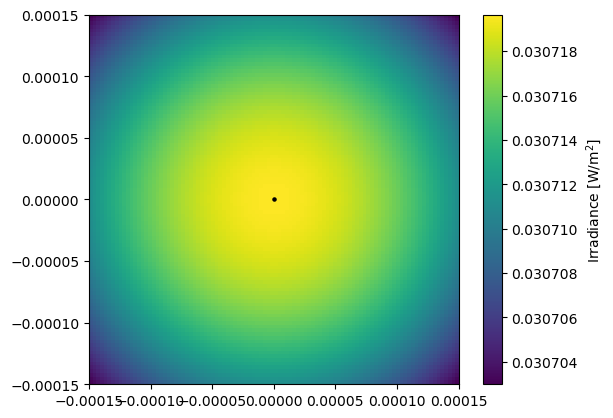

In [3]:
# Compute beam radius at range R (equation 2.4 in Carlsson)
w_0 = (BQ * wavelength) / (np.pi * beam_div)
omega = (wavelength * R)/(np.pi * w_0**2)
omega_0 = 1 - R/R_0
w = w_0 * np.sqrt(omega_0**2 + omega**2)
# pixels for plotting energy distribution
xs, ys = np.meshgrid(np.linspace(-receiver_fov/2, receiver_fov/2, 100),
                     np.linspace(-receiver_fov/2, receiver_fov/2, 100))
r2s = np.square(xs) + np.square(ys)
# compute irradiance
Is = (w_0/w) ** 2 * np.exp(-2*r2s/w**2)

plt.figure()
plt.imshow(Is, extent=(-receiver_fov/2, receiver_fov/2, -receiver_fov/2, receiver_fov/2),
           cmap='viridis', clim=(np.min(Is), np.max(Is)))
# plot the beam centre
plt.colorbar(label="Irradiance [W/m$^2$]")
plt.scatter([0], [0], color="black", s=5)
plt.show()

Now we sample the footprint with subrays using concentric circles which . The number of subrays is governed by the $beamSampleQuality$ ($BSQ$) parameter in HELIOS++, which is the number of concentric circles where subrays are sampled from. On each of these circles, $k$ subrays are sampled, where $k = [2 \pi n]$, and distributed evenly on the circle. The number of subrays for a certain $BSQ$ can hence be calculated as:

$$ n_{rays} = 1 + \sum_{i=1}^{BSQ}\lfloor 2 \pi i \rfloor $$

Each of the subrays has an area assigned, so that all subray areas sum up to the whole footprint area, and this area stays the same for any value of $BSQ$. Let's visualize the rays sampling and the assigned subray areas for $BSQ$ = 8.

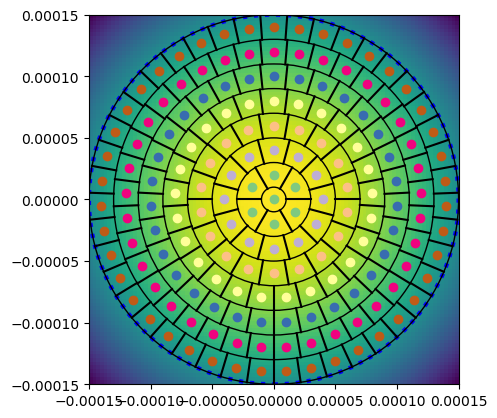

In [4]:
bsq = 8
plt.figure()
# irradiance
plt.imshow(Is, extent=(-receiver_fov/2, receiver_fov/2, -receiver_fov/2, receiver_fov/2),
                 cmap='viridis');
# beam div
circle = plt.Circle((0, 0), beam_div / 2, fill=False, color='blue', linestyle=':', linewidth=3)
plt.gca().add_artist(circle)
    
# go through each concentric circle (defined by the beam sample quality)
for i_circle in range(bsq):
    # determine how many subrays go into the circle (1 for central ray, 6 for first circle, 12 for the second, etc.)
    n_sub = int(i_circle * np.pi * 2) if i_circle > 0 else 1  # special case for central subray
    angle_rho = receiver_fov/2 * (i_circle/(bsq-0.5))  # subtract 0.5 so that the distance between
    ## the outermost circle and the boundary is the same as 1/2 the distance between the circles.
    # next iteration is for the subrays within each circle
    for i_sub in range(n_sub):
        angle_phi = i_sub/n_sub * 2 * np.pi
        x, y = polar2cart(angle_rho, angle_phi)
        # plot subray position
        cmap = matplotlib.colormaps['Accent']
        plt.gca().scatter(x, y, color=cmap(i_circle/(bsq+1)))

        # plot lines to show the segments / areas that the subrays "cover"
        if i_circle > 0:
            line_end = polar2cart(angle_rho + receiver_fov/4/(bsq-0.5), angle_phi - 1/n_sub*np.pi)
            line_start = polar2cart(angle_rho - receiver_fov/4/(bsq-0.5), angle_phi - 1/n_sub*np.pi)
            plt.gca().plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], 'k')

    # plot concentric circle
    radius = (angle_rho + receiver_fov/2 * (0.5/(bsq-0.5)))
    circle = plt.Circle((0, 0), radius, fill=False)
    plt.gca().add_artist(circle)

## Subray area and subray power

The areas of the subrays in a $BSQ$-circle are calculated as:

$$A_{subray} = \pi \frac{r_{outer}^2 - r_{inner}^2}{n_{subrays}}$$

In [5]:
def calc_subray_area(radius_outer, radius_inner, n_subrays):
    area_subray = (np.pi * (radius_outer**2 - radius_inner**2)  # outer circle - inner circle
                   / n_subrays)  # divided by n
    return area_subray

<img src="subray_area_fin.png" width="500">

Recall the Gaussian irradiance distribution

$$I(r) = (\frac{w_0}{w})^2 \rm e^{\frac{-2r^2}{w^2}}$$

The subray power is derived by calculating the integral of the Gaussian irradiance distribution over the interval of the subray.

$$ \int_{r_1}^{r_2} \int_{0}^{2 \pi} \,I(r) \,d\varphi \,r \,dr $$

Then from $ \int_{0}^{2 \pi} d\varphi $ it follows $2 \pi \int_{r_1}^{r_2} r \,I(r) \,dr$

Now $\int r \, I(r) \, dr = - \frac{w_0^2}{4} \rm e^{-2 \frac{r^2}{w^2}} = F(r) $

For then $\int_{r_1}^{r_2} r \, I(r) \, dr = F(r_2) - F(r_1) $ \
$= - \frac{w_0^2}{4} \rm e^{-2 \frac{r_2^2}{w^2}} + \frac{w_0^2}{4} \rm e^{-2 \frac{r_1^2}{w^2}}$ \
$ = - \frac{w_0^2}{4} \left( \rm e^{-2 \frac{r_2^2}{w^2}} - \rm e^{-2 \frac{r_1^2}{w^2}} \right)$

Finally 

$$ \int_{r_1}^{r_2} \int_{0}^{2 \pi} \,I(r) \,d\varphi \,r \,dr = - \frac{\pi w_0^2}{2} \left( \rm e^{\frac{-2}{w^2}r_2^2} - \rm e^{\frac{-2}{w^2} r_1^2} \right)$$

where $r_1$ is the inner radius and $r_2$ is the outer radius of the current circle.

So to calculate the power of each subray, we can use the following formula:

$$P_{subray} = - \frac{\pi w_0^2}{2 n_{subrays}} (\rm e^{\frac{-2}{w^2} r_{outer}^2} - \rm e^{\frac{-2}{w^2} r_{inner}^2}) P_{tot}$$

In [6]:
def calc_subray_power(w_0, n_sub, w, radius, prev_radius, tot_power):
    power_subray = -1 * np.pi * w_0**2 / (2*n_sub) * (
        np.exp(-2/(w*w) * (radius)**2) -
        np.exp(-2/(w*w) * (prev_radius)**2)
    ) * tot_power
    return power_subray

## Cross section and light models / BDRF

The effective target cross section (backscattering cross-section) is calculated as:

$\sigma = 4 \pi A cos(\alpha) BDRF $

Depending on the chosen light model, the BDRF is defined as: 

a) Non-directional \
$BDRF =  \frac{\rho}{cos(\alpha)}$ \
b) Lambert \
$BDRF = \rho$ \
c) Phong \
$ BDRF = \rho \left[ \left( 1 - k_s\right) + k_s \frac{cos(2 \alpha)^{Ns}}{cos(\alpha)} \right] $

so the laser cross section $\sigma$ is calculated in one of the following ways:

a) Non-directional \
$\sigma = 4\pi A \cdot \rho $ \
b) Lambert \
$\sigma = 4\pi A \cdot cos(\alpha) \cdot \rho $ \
c) Phong \
$\sigma = 4\pi A \cdot \rho \left[ \left( 1 - k_s\right) + k_s \frac{cos(2 \alpha)^{Ns}}{cos(\alpha)} \right] $

In [7]:
class MODES(enum.Enum):
    NONDIR = "nondir"
    LAMBERT = "lambert"
    PHONG = "phong"

def calc_sigma(mode, rho, area_at_surface, alpha=None, spec=None, Ns=None):
    if mode == MODES.NONDIR:
        sigma = 4 * np.pi * rho * area_at_surface  # "non-directional"
    elif mode == MODES.LAMBERT:
        sigma = 4 * np.pi * rho * area_at_surface * np.cos(alpha)  # "Lambert": Hoefle & Pfeifer 2007 (Eq. 5)
    elif mode == MODES.PHONG:
        sigma = 4 * np.pi * rho * ((1 - spec) + spec * ((np.cos(2*alpha)**Ns)/np.cos(alpha))) * area_at_surface  # "Phong": Phong 1975

    return sigma

## Received subray power

In our sampling scheme, we assume that
- each subray is circular (defined by the theoretical subray beam divergence $\beta_{subray}$ and the Range $R$.
- the entire footprint of the subray is reflected on one surface (extended target)

By rearranging the formula for the target area $A_s = \frac{\pi R^2 \beta^2}{4}$ (Höfle & Pfeifer 2007, eq. 4), we can determine the theoretical subray beam divergence $\beta_{subray}$.

$$\beta_{subray} = \frac{2 \sqrt{A_s}}{\sqrt{\pi} R}$$

Now, we have all variables to calculate the received power of each subray using the laser radar equation:

$$P_{r,subray} = \frac{P_{subray} D_r^2}{4 \pi R^4 \beta_{subray}^2} \eta_{sys} \eta_{atm} \sigma$$

In [8]:
def calc_subray_rec_power(area, range, power_subray, D_r, eta_sys, eta_atm, sigma):
    beam_div_from_area = np.sqrt(area / np.pi) / range * 2
    rec_power_subray = (power_subray * D_r ** 2) / (4 * np.pi * range ** 4 * beam_div_from_area ** 2) * eta_sys * eta_atm  * sigma

    return rec_power_subray

## Putting it all together

Let's add these calculations into our subray creation loop and make the $BSQ$, the light model, the incidence angle $alpha$ and the range $R$ interactive.

In [9]:
def addlabels(ax, x, y, max, fmt='.4f',):
    vspace = 0.01*max
    for i in range(len(x)):
        ax.text(i, y[i] + vspace, f"{y[i]:{fmt}}", ha='center', rotation=40)
        
def helios_light_model(bsq, light_model, incidence_angle, R):
    # set fix variables
    beam_div = 0.3  # [mrad], 1/e2 points (full angle)
    receiver_fov = beam_div
    tot_power = 4  # [W]
    eta_atm = 1  # efficiency of the atmosphere
    eta_sys = 1  # efficiency of the system
    D_r = 1  # diameter of the receiver aperture [m]
    wavelength = 1064 * 1e-9  # [m]
    R_0 = 1.5  # minimum range [m]
    reflectance = 0.5
    spec = 0.5  # weight for the specular contribution; only used in the Phong model
    Ns = 10
    alpha = incidence_angle * np.pi/180
    BQ = 2
    # pixels for plotting energy distribution
    xs, ys = np.meshgrid(np.linspace(-receiver_fov/2, receiver_fov/2, 100),
                         np.linspace(-receiver_fov/2, receiver_fov/2, 100))
    num_x = xs.shape[0]
    num_y = xs.shape[1]
    
    # Compute beam radius at range R (equation 2.4 in Carlsson)
    w_0 = (BQ * wavelength) / (np.pi * beam_div)
    omega = (wavelength * R) / (np.pi * w_0**2)
    omega_0 = 1 - R/R_0
    w = w_0 * np.sqrt(omega_0**2 + omega**2)
    
    tot_power = 2*tot_power / (np.pi * w_0**2)  # reversing/undoing Eq. 2.3 in Carlsson
    
    # squared radii
    r2s = np.square(xs) + np.square(ys)
    # compute irradiance
    Is = (w_0/w) ** 2 * np.exp(-2*r2s/w**2)

    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    # irradiance
    axs[0, 0].imshow(Is, extent=(-receiver_fov/2, receiver_fov/2, -receiver_fov/2, receiver_fov/2),
               cmap='viridis')
    
    try:
        l_mode = MODES(light_model)
    except:
        print(f"Light model {light_model} not valid. Setting to non-directional")
        l_mode = MODES.NONDIR

    power_subrays = []
    n_subrays = []
    area_subrays = []
    rec_power_subrays = []
    
    prev_radius_m = 0
    prev_radius = 0
    # go through each concentric circle (defined by the beam sample quality)
    for i_circle in range(bsq):
        # determine how many subrays go into the circle (1 for central ray, 6 for first circle, 12 for the second, etc.)
        n_sub = int(i_circle * np.pi * 2) if i_circle > 0 else 1  # special case for central subray
        angle_rho = receiver_fov/2 * (i_circle/(bsq-0.5))  # subtract 0.5 so that the distance between
        ## the outermost circle and the boundary is the same as 1/2 the distance between the circles.
        # next iteration is for the subrays within each circle
        for i_sub in range(n_sub):
            angle_phi = i_sub/n_sub * 2 * np.pi
            x, y = polar2cart(angle_rho, angle_phi)
            # plot subray position
            cmap = matplotlib.colormaps['Accent']
            axs[0, 0].scatter(x, y, color=cmap(i_circle/(bsq+1)))
    
            # plot lines to show the segments / areas that the subrays "cover"
            if i_circle > 0:
                line_end = polar2cart(angle_rho + receiver_fov/4/(bsq-0.5), angle_phi - 1/n_sub*np.pi)
                line_start = polar2cart(angle_rho - receiver_fov/4/(bsq-0.5), angle_phi - 1/n_sub*np.pi)
                axs[0, 0].plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], 'k')
    
        # plot concentric circle
        radius = (angle_rho + receiver_fov/2 * (0.5/(bsq-0.5)))
        circle = plt.Circle((0, 0), radius, fill=False)
        axs[0, 0].add_artist(circle)
        
        power_subray = calc_subray_power(w_0, n_sub, w, radius, prev_radius, tot_power)

        # area of each subray in the circle
        radius_m = radius * R
        area_subray = calc_subray_area(radius_m, prev_radius_m, n_sub)
        prev_radius_m = radius_m  # save radius for the next circle
        prev_radius = radius  # save radius for the next circle
    
        sigma = calc_sigma(mode=l_mode, rho=reflectance, area_at_surface=area_subray, alpha=alpha, spec=spec, Ns=Ns)
    
        # Laser/radar eq.
        rec_power_subray = calc_subray_rec_power(area=area_subray, range=R, power_subray=power_subray, D_r=D_r, eta_sys=eta_sys, eta_atm=eta_atm, sigma=sigma)
        
        power_subrays.append(power_subray)
        area_subrays.append(area_subray)
        n_subrays.append(n_sub)
        rec_power_subrays.append(rec_power_subray)

    power_subrays = np.array(power_subrays)
    rec_power_subrays = np.array(rec_power_subrays)
    n_subrays = np.array(n_subrays)
    # beam div
    circle = plt.Circle((0, 0), beam_div / 2, fill=False, color='blue', linestyle=':', linewidth=3)
    axs[0, 0].add_artist(circle)
    axs[0, 0].set_aspect('equal', 'box')
    axs[0, 0].set_xlim([-receiver_fov/2, receiver_fov/2])
    axs[0, 0].set_ylim([-receiver_fov/2, receiver_fov/2])
    axs[0, 0].set_title('Subrays and irradiance')

    axs[0, 1].bar(range(len(power_subrays)), power_subrays*n_subrays, color='grey', label='Sum over areas at circle')
    axs[0, 1].bar(range(len(power_subrays)), power_subrays, color='blue', label='Single area at circle')
    addlabels(axs[0, 1], range(bsq), power_subrays, max=max(power_subrays*n_subrays), fmt='.2e')
    axs[0, 1].set_title('Power per subray at different concentric levels [W]')
    axs[0, 1].set_xlabel('Circle index')
    axs[0, 1].set_ylabel('Subray power [W]')
    axs[0, 1].legend()

    axs[0, 2].bar(range(len(area_subrays)), area_subrays*n_subrays, color='grey', label='Sum over subrays at circle')
    axs[0, 2].bar(range(len(area_subrays)), area_subrays, color='blue', label='Single subray at circle')
    addlabels(axs[0, 2], range(bsq), area_subrays, max=max(area_subrays*n_subrays))
    axs[0, 2].set_title(f'Total area: {np.sum(area_subrays*n_subrays):.3f} [m²]\n'
                        'Area per subray at different concentric levels')
    axs[0, 2].set_xlabel('Circle index')
    axs[0, 2].set_ylabel('Subray area [m$^2$]')
    axs[0, 2].legend()

    axs[1, 0].pie(power_subrays * n_subrays, labels=range(len(power_subrays)))
    axs[1, 0].set_title('Power contribution from subray levels\n'
                        f'Total power: {np.sum(power_subrays*n_subrays):.3f} [W] '
                        f'(Receiver FoV multiplier: {receiver_fov/beam_div:.2f})')

    axs[1, 1].bar(range(len(rec_power_subrays)), rec_power_subrays*n_subrays, color='grey', label='Sum over subrays at circle')
    axs[1, 1].bar(range(len(rec_power_subrays)), rec_power_subrays, color='blue', label='Single subray at circle')
    addlabels(axs[1, 1], range(bsq), rec_power_subrays, max=max(rec_power_subrays*n_subrays), fmt='.2e')
    axs[1, 1].set_title(f'Total received power: {np.sum(rec_power_subrays*n_subrays):.3e} [W]\n'
                'Received power per subray at different concentric levels')
    axs[1, 1].set_xlabel('Circle index')
    axs[1, 1].set_ylabel('Subray received power [W]')
    axs[1, 1].legend()
    plt.tight_layout()

In [10]:
interact(helios_light_model, 
         bsq=widgets.IntSlider(value=8, min=1, max=10, step=1, description='Beam Sample Quality'),
         light_model=widgets.Dropdown(options=['nondir', 'lambert', 'phong'], description='Light model'),
         incidence_angle=widgets.IntSlider(value=0, min=0, max=85, step=5, description='Incidence angle [°]'),
         R=widgets.IntSlider(value=10, min=1, max=100, step=1, description='Range [m]')
);

interactive(children=(IntSlider(value=8, description='Beam Sample Quality', max=10, min=1), Dropdown(descripti…